<a href="https://colab.research.google.com/github/davidbro-in/pds-fir-pipeline/blob/main/notebooks/fir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

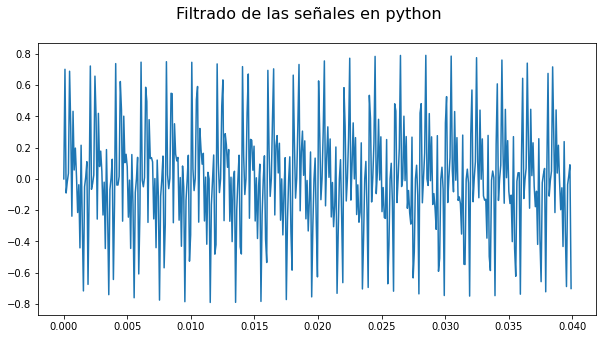

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fs = 11025
sec = 0.04
t = np.arange(0, fs*sec, 1)/fs

# Tonos generados a inyectar al sistema de filtrado
tones = (np.sin(2*np.pi * 500 *t) + np.sin(2*np.pi * 2500 *t) + np.sin(2*np.pi * 3000 *t) + np.sin(2*np.pi * 4500 *t))/4

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Filtrado de las señales en python", fontsize=16)
signalAxes, = plt.plot(t, tones)
